In [145]:
#https://towardsdatascience.com/the-practical-guide-for-object-detection-with-yolov5-algorithm-74c04aac4843
#https://medium.com/@thamqianyu96/coco-to-yolo-annotations-9d638bb3eb4f
#https://github.com/cocodataset/cocoapi/blob/master/PythonAPI/pycocotools
#https://towardsdatascience.com/coco-data-format-for-object-detection-a4c5eaf518c5
#https://colab.research.google.com/drive/1Er0DDo9xFg1ygDqWIfoJhNRQKazf36f6?authuser=1#scrollTo=kTvDNSILZoN9
#https://github.com/ultralytics/yolov5/wiki/Train-Custom-Data

#PENDIENTES:

#-ORDENAR CARPETAS EN IMAGES Y LABELS COMO ESTA LA FOTO DE DIRECTORY MAS ABAJO

In [146]:
#Mount google drive in order to get the data
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [147]:
#reset the status of the annotations folder to before
import os

#delete the new annotations train and validation file
!rm '/content/drive/MyDrive/Code Challenges/Memorable/grozi_coco/annotations/instances_train2017.json'
!rm '/content/drive/MyDrive/Code Challenges/Memorable/grozi_coco/annotations/instances_val2017.json'
!rmdir '/content/drive/MyDrive/Code Challenges/Memorable/grozi_coco/labels/'

# Absolute path of a file
old_name_train = r'/content/drive/MyDrive/Code Challenges/Memorable/grozi_coco/annotations/old_instances_train2017.json'
new_name_train = r'/content/drive/MyDrive/Code Challenges/Memorable/grozi_coco/annotations/instances_train2017.json'

old_name_val = r'/content/drive/MyDrive/Code Challenges/Memorable/grozi_coco/annotations/old_instances_val2017.json'
new_name_val = r'/content/drive/MyDrive/Code Challenges/Memorable/grozi_coco/annotations/instances_val2017.json'


# Renaming the file
try:
  os.rename(old_name_train, new_name_train)
  os.rename(old_name_val, new_name_val)
except:
  print('There was no older version of the annotations!')

rmdir: failed to remove '/content/drive/MyDrive/Code Challenges/Memorable/grozi_coco/labels/': Directory not empty


In [148]:
#clone YOLOv5 and 
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
%pip install -qr requirements.txt # install dependencies

fatal: destination path 'yolov5' already exists and is not an empty directory.
/content/drive/MyDrive/Code Challenges/Memorable/grozi_coco/images/val2017/yolov5


In [149]:
import torch
torch.cuda.empty_cache()
from IPython.display import Image, clear_output  # to display images

print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Setup complete. Using torch 1.10.0+cu111 (Tesla K80)


In [150]:
# import cv2
# import torch
# from PIL import Image

# # Model
# model = torch.hub.load('ultralytics/yolov5', 'yolov5s')

# # Images

# img1 = Image.open('/content/drive/MyDrive/Code Challenges/Memorable/grozi_coco/train2017/0.jpg')  # PIL image
# img2 = cv2.imread('/content/drive/MyDrive/Code Challenges/Memorable/grozi_coco/train2017/1.jpg')[..., ::-1]  # OpenCV image (BGR to RGB)
# imgs = [img1, img2]  # batch of images

# # Inference
# results = model(imgs, size=640)  # includes NMS

# # Results
# results.print()  
# results.save()  # or .show()

# results.xyxy[0]  # img1 predictions (tensor)
# results.pandas().xyxy[0]  # img1 predictions (pandas)


In [151]:
#As a first inference, we can see in the result that the model with its pretrained weights
#can not take the grocery products as a whole and tries to detect on the pictures of the etiquettes >> how can be this fixed? custom training

Notes: 
- When exploring the annotations for the training set, the categories section looks like it has a category per picture and not per item/grocery product

Actual example of the output of annotations section: 

```
"annotations": [
        {
            "area": 248115,
            "iscrowd": 0,
            "bbox": [
                350,
                0,
                417,
                595
            ],
            "category_id": 0,
            "ignore": 0,
            "segmentation": [],
            "image_id": 0,
            "id": 0
        },

```



- The annotations section:


> Contains list of each individual object annotation from every single image in the dataset. This is the section that contains the bounding box output or object segmentation for object detection

> If an image has 4 objects that we want to detect then we will have annotations for all 4 objects.

> segmentation contains the x and y coordinates for the vertices of the polygon around every object instance for the segmentation masks. >>> In this case is empty for all images (VERIFICAR Y DEMOSTRAR ESTO)

> area is the area of the bounding box. It is a pixel value

>iscrowd: If we have a single object segmentation then iscrowd is set to zero. For a collection of objects present in the image, we set iscrowd=1 >> it seems iscrowd is always = 0 (VERIFICAR Y DEMOSTRAR ESTO)

>imageid: It is the id of the image which contains the objects for which we are specifying the annotations . The imageid corresponds to the imageid that we have in the image section

>bbox : Bounding box in COCO is the x and y co-ordinate of the top left and the height and width. 
- COCO Bounding box: (x-top left, y-top left, width, height)

>id: It is the unique id for the annotations


### Explore the dataset with the help of the COCO API (pyCoco)

In [152]:
#https://github.com/cocodataset/cocoapi/blob/master/PythonAPI/pycocoDemo.ipynb

In [153]:
#import libraries
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

In [154]:
#get the file path to the train dataset (both images and their annotations)
dataDir='/content/drive/MyDrive/Code Challenges/Memorable/grozi_coco'
dataType='train2017'
train_images_dir = dataDir+'/'+dataType
annFile='{}/annotations/instances_{}.json'.format(dataDir,dataType)

In [155]:
annFile

'/content/drive/MyDrive/Code Challenges/Memorable/grozi_coco/annotations/instances_train2017.json'

In [156]:
# initialize COCO api for instance annotations
coco=COCO(annFile)

loading annotations into memory...
Done (t=0.16s)
creating index...
index created!


In [157]:
# display COCO categories and supercategories
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(' '.join(nms)))

nms = set([cat['supercategory'] for cat in cats])
print('COCO supercategories: \n{}'.format(' '.join(nms)))

COCO categories: 
0.jpg 1.jpg 2.jpg 3.jpg 4.jpg 5.jpg 6.jpg 7.jpg 8.jpg 9.jpg 10.jpg 11.jpg 413.jpg 13.jpg 14.jpg 15.jpg 16.jpg 17.jpg 18.jpg 19.jpg 20.jpg 21.jpg 1001.jpg 22.jpg 23.jpg 28.jpg 29.jpg 26.jpg 27.jpg 31.jpg 32.jpg 33.jpg 1221.jpg 35.jpg 36.jpg 37.jpg 34.jpg 38.jpg 39.jpg 1218.jpg 41.jpg 42.jpg 43.jpg 44.jpg 45.jpg 46.jpg 54.jpg 47.jpg 48.jpg 49.jpg 50.jpg 56.jpg 52.jpg 53.jpg 55.jpg 51.jpg 57.jpg 58.jpg 59.jpg 60.jpg 61.jpg 62.jpg 63.jpg 67.jpg 68.jpg 69.jpg 70.jpg 71.jpg 72.jpg 73.jpg 74.jpg 75.jpg 76.jpg 77.jpg 78.jpg 79.jpg 599.jpg 81.jpg 601.jpg 83.jpg 89.jpg 90.jpg 91.jpg 1007.jpg 93.jpg 1008.jpg 95.jpg 96.jpg 97.jpg 98.jpg 99.jpg 100.jpg 101.jpg 92.jpg 102.jpg 103.jpg 104.jpg 1009.jpg 106.jpg 107.jpg 94.jpg 108.jpg 109.jpg 110.jpg 111.jpg 1010.jpg 113.jpg 114.jpg 115.jpg 112.jpg 116.jpg 117.jpg 105.jpg 120.jpg 121.jpg 122.jpg 125.jpg 126.jpg 127.jpg 128.jpg 129.jpg 130.jpg 131.jpg 123.jpg 132.jpg 133.jpg 1011.jpg 136.jpg 137.jpg 139.jpg 140.jpg 141.jpg 142.jpg 143.j

it seems that the categories are the names of the pictures and that no classes for the objects were uploaded when labeling the data

In [158]:
#image to see the annotations
image_name = '0.jpg'
image_id = 0

In [159]:
coco.getCatIds(catNms=[image_name])

[0]

In [160]:
coco.getImgIds(catIds=[0])

[0, 1, 229, 230, 343, 344, 345, 346, 219, 220]

In [161]:
#Load the json files of the annotations
import json
import pandas as pd
from pandas.io.json import json_normalize


with open('/content/drive/MyDrive/Code Challenges/Memorable/grozi_coco/annotations/instances_train2017.json') as json_file:
    data = json.load(json_file)
    #dump the json file to see the structure
    data_dump = json.dumps(data, indent=4)


annotations_df = json_normalize(data)
annotations_df = annotations_df.explode('annotations')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  del sys.path[0]


In [162]:
annotations_df

,images,type,annotations,categories
0,"[{'file_name': '0.jpg', 'height': 2448, 'width...",instances,"{'area': 248115, 'iscrowd': 0, 'bbox': [350, 0...","[{'supercategory': 'none', 'id': 0, 'name': '0..."
0,"[{'file_name': '0.jpg', 'height': 2448, 'width...",instances,"{'area': 284580, 'iscrowd': 0, 'bbox': [767, 0...","[{'supercategory': 'none', 'id': 0, 'name': '0..."
0,"[{'file_name': '0.jpg', 'height': 2448, 'width...",instances,"{'area': 287532, 'iscrowd': 0, 'bbox': [1272, ...","[{'supercategory': 'none', 'id': 0, 'name': '0..."
0,"[{'file_name': '0.jpg', 'height': 2448, 'width...",instances,"{'area': 259488, 'iscrowd': 0, 'bbox': [1697, ...","[{'supercategory': 'none', 'id': 0, 'name': '0..."
0,"[{'file_name': '0.jpg', 'height': 2448, 'width...",instances,"{'area': 217005, 'iscrowd': 0, 'bbox': [2105, ...","[{'supercategory': 'none', 'id': 0, 'name': '0..."
...,...,...,...,...
0,"[{'file_name': '0.jpg', 'height': 2448, 'width...",instances,"{'area': 181560, 'iscrowd': 0, 'bbox': [489, 1...","[{'supercategory': 'none', 'id': 0, 'name': '0..."
0,"[{'file_name': '0.jpg', 'height': 2448, 'width...",instances,"{'area': 264110, 'iscrowd': 0, 'bbox': [24, 14...","[{'supercategory': 'none', 'id': 0, 'name': '0..."
0,"[{'file_name': '0.jpg', 'height': 2448, 'width...",instances,"{'area': 478290, 'iscrowd': 0, 'bbox': [1260, ...","[{'supercategory': 'none', 'id': 0, 'name': '0..."
0,"[{'file_name': '0.jpg', 'height': 2448, 'width...",instances,"{'area': 540800, 'iscrowd': 0, 'bbox': [1052, ...","[{'supercategory': 'none', 'id': 0, 'name': '0..."


In [163]:
#get all categories given image id
def GetCategoriesFromImageId(image_id):
    categories = []
    for annotation in data['annotations']:
        if annotation['image_id'] == image_id:
            categories.append(annotation['category_id'])
    return categories

In [164]:
#get all the categories of annotations that are in the image with an id = 0
cat_examples_0 = GetCategoriesFromImageId(0)

In [165]:
# get all images containing given categories, select one at random
catIds = coco.getCatIds(catIds=cat_examples_0);
imgIds = coco.getImgIds(catIds=catIds );
#THERE ARE NO CATEGORIES >> DELETE THE ABOVE CODE

#get random image (10 for example)
imgIds = coco.getImgIds(imgIds = [image_id])
img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]

In [166]:
print(imgIds)
print(catIds)

[0]
[0, 1, 2, 3, 4, 5, 6, 7, 1055]


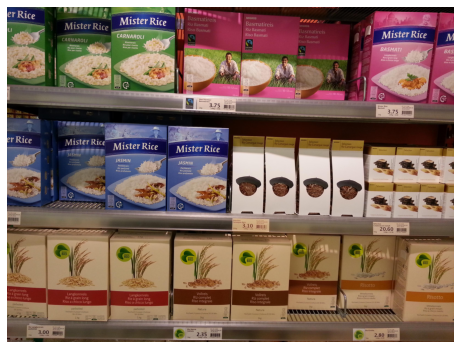

In [167]:
# load and display image
I = io.imread('%s/images/%s/%s'%(dataDir,dataType,img['file_name']))
# use url to load image
#I = io.imread(img['coco_url'])
plt.axis('off')
plt.imshow(I)
plt.show()

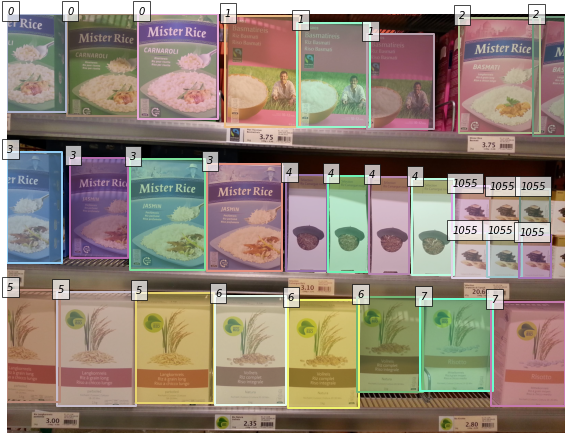

In [168]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(I);plt.axis('off')

annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco.loadAnns(annIds)

coco.showAnns(anns, draw_bbox=True)
for i, ann in enumerate(anns):
    ax.text(anns[i]['bbox'][0], anns[i]['bbox'][1], anns[i]['category_id'], style='italic', 
            bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 5})

In [169]:
#QUEDA PENDIENTE DIVIDIR LAS IMAGENES DEL TRAIN EN TRAIN/TEST ya que TEST != VAL
#VER BIEN LA DIFERENCIA ENTRE TEST Y VAL
#VER BIEN COMO DIVIDIR ENTRE TRAIN Y TEST PARA LO QUE SON FILES/IMAGENES

#### Brief exploration of the files for training and validation

In [170]:
#get the number of classes in the training dataset

def getAllCategoriesFromAnnotations(annotations_filepath):
  
  #load the annotations into a variable
  with open(annotations_filepath) as json_file:
    data = json.load(json_file)

  #append the categories to a list
  categories_ids = []
  categories_names = []


  #loop over the ids in the categories section of the annotations 
  for category in data['categories']:
        categories_ids.append(category['id'])
        categories_names.append(category['name'])

  
  #convert it to set to delete duplicates and back again to a list
  #when converting it to a set it reorders everything
  #categories_ids = list(set(categories_ids)) 
  #categories_names = list(set(categories_names))

  
  print(f' The amount of categories(classes) is: {len(categories_ids)}','\n')
  
  return list(zip(categories_ids,categories_names)),categories_names
  

In [171]:
#output: category_id, category_name
training_classes = getAllCategoriesFromAnnotations('/content/drive/MyDrive/Code Challenges/Memorable/grozi_coco/annotations/instances_train2017.json')

number_of_classes = len(training_classes)


 The amount of categories(classes) is: 878 



### Relabeling the classes ids

When trying to use the model for training, an error will be raised regarding number of classes. 

The number of classes must be of exact match to the index number of the classes. For example, there are 878 classes but there is an id with number 1055, so an error is raised. The id number of any category muss be less or equal to number of classes (nc). 

We will reindex the ids in the categories section of the annotations and afterwards in the annotations section and save everything into a new json file.

In [172]:
#make a copy of the annotations object for trials
#annotations_copy = data.copy()

with open('/content/drive/MyDrive/Code Challenges/Memorable/grozi_coco/annotations/instances_train2017.json') as json_file:
    annotations_train_copy = json.load(json_file)

with open('/content/drive/MyDrive/Code Challenges/Memorable/grozi_coco/annotations/instances_val2017.json') as json_file:
    annotations_val_copy = json.load(json_file)

In [173]:
ann_files = ['train','val']
vars()['train'] = annotations_train_copy
vars()['val'] = annotations_val_copy

In [174]:
vars()['train']['categories'][12]

{'id': 413, 'name': '413.jpg', 'supercategory': 'none'}

In [175]:
#change the category ids so that the index is the category id
index = 0
replacement_dict = {}

for ann in ann_files:
  for category in vars()[ann]['categories']: #annotations_train_copy['categories']:
    #save the replacement into a dict so it can be used later for the annotations section
    replacement_dict[category['id']] = index
    #replace the id 
    category['id'] = index

    index += 1
      

In [176]:
#checking the result of replacement in the categories section of the annotation
vars()['train']['categories'][12] #id = 12 >> proof of the change because before it would have been id = 413, name = 413.jpg

{'id': 12, 'name': '413.jpg', 'supercategory': 'none'}

In [177]:
# #{k: v for k, v in replacement_dict.items() if v == 413}
# #print(len(replacement_dict))

# # Python code to demonstrate 
# # finding duplicate values from dictionary
# from itertools import chain
  
 
# # finding duplicate values
# # from dictionary using set
# duplicates_dict = {}
# for key, value in replacement_dict.items():
#     duplicates_dict.setdefault(value, set()).add(key)
  
  
# result = set(chain.from_iterable(
#          values for key, values in duplicates_dict.items()
#          if len(values) > 1))
  
# # printing result
# print("resultant key", str(result))

In [178]:
for old_id, new_id in replacement_dict.items():
  if old_id == 413:
    print(f'old_id: {old_id} and new_id: {new_id}')
#BORRAR

old_id: 413 and new_id: 12


In [179]:
for annotation in vars()['train']['annotations']: #annotations_train_copy['annotations']:

  if annotation['category_id'] == 64:
    print(annotation)

{'area': 1671318, 'iscrowd': 0, 'bbox': [0, 1729, 1101, 1518], 'category_id': 64, 'ignore': 0, 'segmentation': [], 'image_id': 115, 'id': 1359}
{'area': 723713, 'iscrowd': 0, 'bbox': [0, 1991, 677, 1069], 'category_id': 64, 'ignore': 0, 'segmentation': [], 'image_id': 116, 'id': 1367}
{'area': 896112, 'iscrowd': 0, 'bbox': [1664, 2121, 784, 1143], 'category_id': 64, 'ignore': 0, 'segmentation': [], 'image_id': 117, 'id': 1375}


In [180]:
print(f'The new id for the category_id = 64 is {replacement_dict[64]}')

The new id for the category_id = 64 is 199


In [181]:
#change the category ids in the annotations section according to the replacement dict
for ann in ann_files:
  for annotation in vars()[ann]['annotations']: #annotations_train_copy['annotations']:
    annotation['category_id'] = replacement_dict[annotation['category_id']]

In [182]:
#checking if the change was made
for annotation in vars()['train']['annotations']: #annotations_train_copy['annotations']:

  if annotation['category_id'] == 199:
    print(annotation)

{'area': 1671318, 'iscrowd': 0, 'bbox': [0, 1729, 1101, 1518], 'category_id': 199, 'ignore': 0, 'segmentation': [], 'image_id': 115, 'id': 1359}
{'area': 723713, 'iscrowd': 0, 'bbox': [0, 1991, 677, 1069], 'category_id': 199, 'ignore': 0, 'segmentation': [], 'image_id': 116, 'id': 1367}
{'area': 896112, 'iscrowd': 0, 'bbox': [1664, 2121, 784, 1143], 'category_id': 199, 'ignore': 0, 'segmentation': [], 'image_id': 117, 'id': 1375}


In [183]:
ann_files

['train', 'val']

In [184]:
#change the name of the old annotations file 

# Absolute path of a file
#old_name = r'/content/drive/MyDrive/Code Challenges/Memorable/grozi_coco/annotations/instances_train2017.json'
#new_name = r'/content/drive/MyDrive/Code Challenges/Memorable/grozi_coco/annotations/old_instances_train2017.json'

# Renaming the file
#os.rename(old_name, new_name)

#now, let's save all the modifications into a new annotations file
for ann in ann_files:
  old_name = r'/content/drive/MyDrive/Code Challenges/Memorable/grozi_coco/annotations/instances_'+ann+'2017.json'
  new_name = r'/content/drive/MyDrive/Code Challenges/Memorable/grozi_coco/annotations/old_instances_'+ann+'2017.json'

  os.rename(old_name, new_name)

  with open('/content/drive/MyDrive/Code Challenges/Memorable/grozi_coco/annotations/instances_'+ ann +'2017.json', 'w') as outfile:
    #json.dump(annotations_train_copy, outfile)
    json.dump(vars()[ann], outfile)

After relabeling the category_ids, the object that was saving the classes names remained outdated, so we will run again the function to extract them with the new ids:

In [185]:
#output: category_id, category_name
training_classes,training_classes_names = getAllCategoriesFromAnnotations('/content/drive/MyDrive/Code Challenges/Memorable/grozi_coco/annotations/instances_train2017.json')

number_of_classes = len(training_classes)


 The amount of categories(classes) is: 878 



In [186]:
#get the max value of the ids, to check if there is a number higher than 878
max(training_classes,key=lambda item:item[0])

(877, '333.jpg')

### YOLOv5 formatting

To achieve a robust YOLOv5 model, it is recommended to train with over 1500 images per class, and more then 10,000 instances per class. It is also recommended to add up to 10% background images, to reduce false-positives errors. Since my dataset is significantly small, I will narrow the training process using transfer learning technics.

VER COMO ATACAAR ESTE PROBLEMA

>YOLO labeling format

Most annotation platforms support export at YOLO labeling format, providing one annotations text file per image. Each text file contains one bounding-box (BBox) annotation for each of the objects in the image. The annotations are normalized to the image size, and lie within the range of 0 to 1. They are represented in the following format:

`< object-class-ID> <X center> <Y center> <Box width> <Box height>`

If there are two objects in the image, the content of the YOLO annotations text file might look like this:

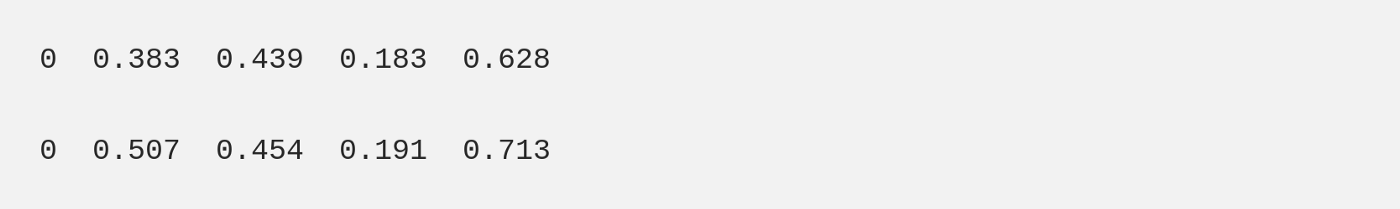

In [187]:
#https://github.com/qwirky-yuzu/COCO-to-YOLO/blob/main/coco_to_yolo.py

from json import JSONDecodeError
from os import path
import json
import pathlib


class ConvertCOCOToYOLO:
    """
    Takes in the path to COCO annotations and optional the path, where the YOLO annotations shall be saved
    in multiple .txt files.
    COCO annotation are to be JSON formart as follows:
        "annotations":{
            "area":2304645,
            "id":1,
            "image_id":10,
            "category_id":4,
            "bbox":[
                0::704
                1:620
                2:1401
                3:1645
            ]
        }
        
    """

    def __init__(self, json_path, label_path):
        self.json_path = json_path
        self.label_path = label_path

    def check_paths(self):
        #if self.label_path is None or not path.exists(self.label_path):
         #   self.label_path = pathlib.Path(__file__).parent.resolve()
        if self.json_path is None:
            return False
        if path.exists(self.json_path):
            try:
                json.load(open(self.json_path))
                return True
            except JSONDecodeError:
                print("cant't open Json File")
                return False
        else:
            return False

    def convert_labels(self, x1, y1, x2, y2, size):
        """
        Definition: Parses label files to extract label and bounding box
        coordinates. Converts (x1, y1, x1, y2) KITTI format to
        (x, y, width, height) normalized YOLO format.
        """

        def sorting(l1, l2):
            if l1 > l2:
                lmax, lmin = l1, l2
                return lmax, lmin
            else:
                lmax, lmin = l2, l1
                return lmax, lmin

        xmax, xmin = sorting(x1, x2)
        ymax, ymin = sorting(y1, y2)
        dw = 1. / size[1]
        dh = 1. / size[0]
        x = (xmin + xmax) / 2.0
        y = (ymin + ymax) / 2.0
        w = xmax - xmin
        h = ymax - ymin
        x = x * dw
        w = w * dw
        y = y * dh
        h = h * dh
        return (x, y, w, h)

    def convert(self, annotation_key='annotations', img_id='image_id', cat_id='category_id', bbox='bbox'):

        if not self.check_paths():
            return None

        # Enter directory to read JSON file
        data = json.load(open(self.json_path))

        check_set = set()

        # Retrieve data
        for i in range(len(data[annotation_key])):

            # Get required data
            image_id = f'{data[annotation_key][i][img_id]}'
            category_id = f'{data[annotation_key][i][cat_id]}'
            bbox = data[annotation_key][i]["bbox"]

            # Retrieve Image Name and width and height
            image_name = ""
            image_height = 0
            image_width = 0
            images_metadata = data["images"]
            for image_object in images_metadata:
                if image_object["id"] == int(image_id):
                    image_name = image_object["file_name"]
                    image_width = image_object["width"]
                    image_height = image_object["height"]

            # Convert the data
            kitti_bbox = [bbox[0], bbox[1], bbox[2] + bbox[0], bbox[3] + bbox[1]]
            yolo_bbox = self.convert_labels(kitti_bbox[0], kitti_bbox[1], kitti_bbox[2], kitti_bbox[3],
                                            (image_height, image_width))

            # Prepare for export
            filename = f'{image_name[:-4]}.txt'
            content = f"{category_id} {yolo_bbox[0]} {yolo_bbox[1]} {yolo_bbox[2]} {yolo_bbox[3]}"
            path_to_file = os.path.join(self.label_path, filename)
            # Export 
            if image_id in check_set:
                # Append to existing file as there can be more than one label in each image
                file = open(path_to_file, "a")
                file.write("\n")
                file.write(content)
                file.close()

            elif image_id not in check_set:
                check_set.add(image_id)
                # Write files
                file = open(path_to_file, "w")
                file.write(content)
                file.close()


if __name__ == "__main__":
    # To run in as a class
    ConvertCOCOToYOLO(json_path='dataset/test.json', label_path="dataset/labels").convert()

*Data directories structure*

To comply with Ultralytics directories structure, an example of how the data is provided would be as the following structure:

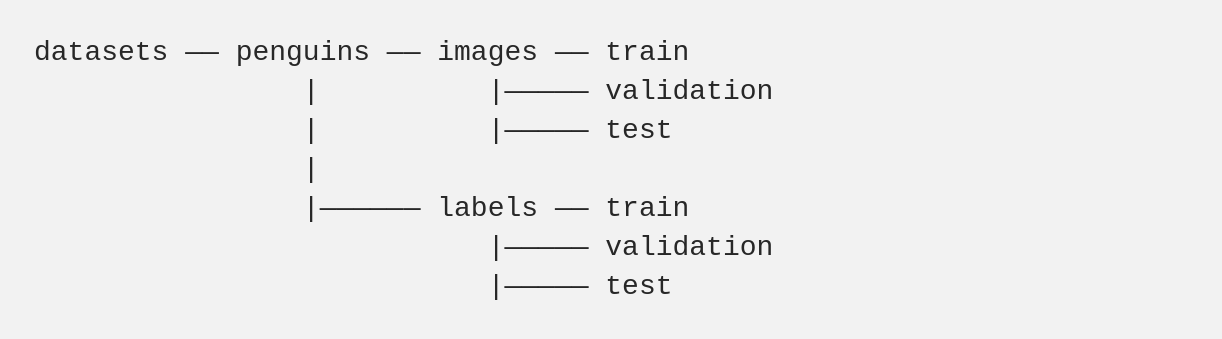

In [188]:
#The following function will generate the data directories splited into train, val, test.
from pathlib import Path

def create_data_directories(data_name):
    Path(f"../drive/MyDrive/Code Challenges/Memorable/{data_name}/labels/train2017").mkdir(parents=True, exist_ok=True)
    Path(f"../drive/MyDrive/Code Challenges/Memorable/{data_name}/labels/val2017").mkdir(parents=True, exist_ok=True)
    
create_data_directories('grozi_coco')

In [189]:
labels_path = '/content/drive/MyDrive/Code Challenges/Memorable/grozi_coco/labels/'

Extract the annotations files (train,val) to labels folders with the YOLOv5 format

In [190]:
ConvertCOCOToYOLO(label_path=labels_path+'train2017',json_path=annFile).convert()

In [191]:
ConvertCOCOToYOLO(label_path=labels_path+'val2017',json_path=annFile).convert()

### Training of the model




In [192]:
#See how many files we have in the training and validation dataset (so it can be taken into account wheather the model is trained)
#from scratch or using the pretrained model with its weights

#Get the directory where the images of the training dataset are stored
%cd /content/drive/MyDrive/Code Challenges/Memorable/grozi_coco/images/train2017

#Get how many images are in the training dataset
train_quantity = len(os.listdir())
print('\n' ,f'The number of images to train the model is: {train_quantity} images','\n' )

#Get the directory where the images of the test dataset are stored
%cd /content/drive/MyDrive/Code Challenges/Memorable/grozi_coco/images/val2017

#Get how many images are in the test dataset
validation_quantity = len(os.listdir())
print('\n' ,f'The number of images to train the model is: {validation_quantity} images')

#get the percentage of train / test split
train_percentage = round(train_quantity / (train_quantity + validation_quantity),2)*100
print('\n' ,f'The percentage of train/test split is {train_percentage}/{100-train_percentage} %')

/content/drive/MyDrive/Code Challenges/Memorable/grozi_coco/images/train2017

 The number of images to train the model is: 597 images 

/content/drive/MyDrive/Code Challenges/Memorable/grozi_coco/images/val2017

 The number of images to train the model is: 86 images

 The percentage of train/test split is 87.0/13.0 %


#### Configuration files

The **data-configurations** file describes the dataset parameters. Since we are training on our custom penguins dataset, we will edit this file and provide: 

- the paths to the train, validation and test (optional) datasets; 
- the number of classes (nc); 
- and the names of the classes in the same order as their index. 

In the dataset provided we only have one class, without name. We named our custom data configurations file as ‘grocery_data.yaml’ and placed it under the ‘data’ directory from the yolov5 repo. 

The content of this YAML file is as follow:

In [193]:
# #define the parameters for the DATA configuration file (file_name.yaml)
yaml_content = '''

train: /content/drive/MyDrive/Code Challenges/Memorable/grozi_coco/images/train2017
val: /content/drive/MyDrive/Code Challenges/Memorable/grozi_coco/images/val2017

nc: 878     #Number of classes 

names: '''+ str(training_classes_names)+'''   #Classes names

'''


In [194]:
#used this YAML validator as it was throwing back error:
# https://codebeautify.org/yaml-validator

In [195]:
print(yaml_content)



train: /content/drive/MyDrive/Code Challenges/Memorable/grozi_coco/images/train2017
val: /content/drive/MyDrive/Code Challenges/Memorable/grozi_coco/images/val2017

nc: 878     #Number of classes 

names: ['0.jpg', '1.jpg', '2.jpg', '3.jpg', '4.jpg', '5.jpg', '6.jpg', '7.jpg', '8.jpg', '9.jpg', '10.jpg', '11.jpg', '413.jpg', '13.jpg', '14.jpg', '15.jpg', '16.jpg', '17.jpg', '18.jpg', '19.jpg', '20.jpg', '21.jpg', '1001.jpg', '22.jpg', '23.jpg', '28.jpg', '29.jpg', '26.jpg', '27.jpg', '31.jpg', '32.jpg', '33.jpg', '1221.jpg', '35.jpg', '36.jpg', '37.jpg', '34.jpg', '38.jpg', '39.jpg', '1218.jpg', '41.jpg', '42.jpg', '43.jpg', '44.jpg', '45.jpg', '46.jpg', '54.jpg', '47.jpg', '48.jpg', '49.jpg', '50.jpg', '56.jpg', '52.jpg', '53.jpg', '55.jpg', '51.jpg', '57.jpg', '58.jpg', '59.jpg', '60.jpg', '61.jpg', '62.jpg', '63.jpg', '67.jpg', '68.jpg', '69.jpg', '70.jpg', '71.jpg', '72.jpg', '73.jpg', '74.jpg', '75.jpg', '76.jpg', '77.jpg', '78.jpg', '79.jpg', '599.jpg', '81.jpg', '601.jpg', '83

In [196]:
# Write the yaml_content to a file

with open('/content/yolov5/data/grocery_data.yaml', 'w') as writefile:
    writefile.write(yaml_content)

In [197]:
#define the size of the model needed based on the size of the images of the dataset
I.shape #ARMAR ALGUNA FUNCION PARA QUE RECORRA EL SHAPE DE TODO EL DATA SET Y SAQUE PROMEDIO DEL TAMAÑO DE LAS IMAGENES

(2448, 3264, 3)

2. The **model-configurations file** dictates the model architecture. 

Ultralytics supports several YOLOv5 architectures, named P5 models, which varies mainly by their parameters size: YOLOv5n (nano), YOLOv5s (small), YOLOv5m (medium), YOLOv5s (large), YOLOv5x (extra large). 

These architecture are suitable for training with image size of 640*640 pixels. Additional series, that is optimized for training with larger image size of 1280*1280, called P6 (YOLOv5n6, YOLOv5s6, YOLOv5m6, YOLOv5l6, YOLOv5x6). P6 models include an extra output layer for detection of larger objects. They benefit the most from training at higher resolution, and produce better results.

Ultralytics provides build-in, model-configuration files for each of the above architectures, placed under the ‘models’ directory. 

If we're training from scratch, we would choose the model-configurations YAML file with the desired architecture (‘YOLOv5n.yaml’ in this tutorial), and just edit the number of classes (nc) parameter to the correct number of classes in your custom data.

When training is initialized from pre-trained weights as we are doing, no need to edit the model-configurations file since the model will be extracted with the pretrained weights.

In [198]:
#------------------------------------------

3. The **hyperparameters-configurations file** defines the hyperparameters for the training, including the learning rate, momentum, losses, augmentations etc. Ultralytics provides a default hyperparameters file under the ‘data/hyp/hyp.scratch.yaml’ directory. 

As it is mostly recommended to start training with default hyperparameters to establish a performance baseline, we won't edit the file.

The YAML configuration files are nested at the following directories:

PEGAR UNA IMAGEN DE COMO QUEDARON LOS DIRECTORIOS! 

In [133]:
#---------------

#### Training from scratch
When having a large enough dataset, the model will benefit most by training from scratch. The weights are randomly initialized by passing an empty string (‘ ‘) to the weights argument. 

> Parameters

- batch — batch size (-1 for auto batch size). Use the largest batch size that your hardware allows for.
- epochs — number of epochs.
- data — path to the data-configurations file.
- cfg — path to the model-configurations file.
- weights — path to initial weights.
- cache — cache images for faster training.
- img — image size in pixels (default — 640).

<br/>

Training is induced by the following command:



In [144]:
#For now we will train the model from scratch. Will see afterwards if it is better to use pretrained

#%cd /content/yolov5
#!rmdir '/content/yolov5/runs/train/exp' --ignore-fail-on-non-empty

#!python /content/yolov5/train.py --batch 16 --epochs 150 --data '/content/yolov5/data/grocery_data.yaml' --weights 'yolov5' --cfg '/content/yolov5/models/yolov5n.yaml' --cache

train: weights=yolov5, cfg=/content/yolov5/models/yolov5n.yaml, data=/content/yolov5/data/grocery_data.yaml, hyp=../../../../../../../yolov5/data/hyps/hyp.scratch-low.yaml, epochs=150, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=../../../../../../../yolov5/runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.1-73-gd51f9b2 torch 1.10.0+cu111 CUDA:0 (Tesla K80, 11441MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.

In [135]:
#RuntimeError: CUDA out of memory. Tried to allocate 4.46 GiB (GPU 0; 11.17 GiB total capacity; 6.97 GiB already allocated; 3.37 GiB free; 7.19 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |\n|---------------------------------------------------------------------------|\n| Active memory         |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from large pool |       0 B  |       0 B  |

## Inference

In [210]:
%cd

!python /content/yolov5/detect.py --weights /content/yolov5/runs/train/exp4/weights/best.pt --img 640 --conf 0.1 --source '/content/drive/MyDrive/Code Challenges/Memorable/grozi_coco/images/val2017'

/root
detect: weights=['/content/yolov5/runs/train/exp4/weights/best.pt'], source=/content/drive/MyDrive/Code Challenges/Memorable/grozi_coco/images/val2017, data=../content/yolov5/data/coco128.yaml, imgsz=[640, 640], conf_thres=0.1, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=../content/yolov5/runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-73-gd51f9b2 torch 1.10.0+cu111 CUDA:0 (Tesla K80, 11441MiB)

Fusing layers... 
YOLOv5n summary: 213 layers, 2947099 parameters, 0 gradients, 8.0 GFLOPs
image 1/84 /content/drive/MyDrive/Code Challenges/Memorable/grozi_coco/images/val2017/126.jpg: 480x640 Done. (0.034s)
image 2/84 /content/drive/MyDrive/Code Challenges/Memorable/grozi_coco/images/val2017/130.jpg: 480x640 Done. (0.034s)
image 3/84 /content/driv